# day18: Support Vector Machines (SVMs) for Binary Classification

# Objectives

* Gain intuition for SVMs as binary classifier on 1D and 2D toy examples
* Compare hinge loss to cross-entropy-from-scores (log loss)
* Understand impact of hyperparameter C

# Outline

* [Part 1: Comparison of SVM and Logistic regression on a toy 1D feature dataset](#part1)
* [Part 2: Comparison of SVM and Logistic regression on a *clean* toy 2D feature dataset](#part2)
* [Part 3: Comparison of SVM and Logistic regression on the *same* toy 2D feature dataset with outliers](#part3)

# Takeaways

* Always tune the `C` hyperparameter to avoid under/overfitting.
* SVMs have advantages over logistic regression:
* -- Can avoid some sensitivity to outliers (hinge loss less sensitive than log loss)
* SVMs have some limitations:
* -- Cannot make *probabilistic* predictions easily (this is easy with logistic regression)

FYI Another limitation is that SVMs cannot do multi-class classification in an elegant way. (Again, this is easy with logistic regression if we just use softmax). Useful to remember, but not a focus here.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import sklearn.linear_model
import sklearn.svm

In [3]:
from scipy.special import expit as logistic_sigmoid

In [4]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Setup: Create 'Toy Outlier Data'

Setup a simple classification task with 1-dim features.

Our training set will be small, and have a significant "outlier".

Just like in day07, let's think about a classification task where:

Each input is just scalar $x$ between -1 and +1.

The "true" label assignment function is as follows:

$$
y(x) = \begin{cases} 
1 & \text{if} ~ x > 0 \\
0 & \text{otherwise}
\end{cases}
$$

We'll generate several points following this "rule".

As well as one point that is an "outlier".

### Make training set with 1-dim. features that has a significant outlier

In [5]:
# We generated this training set for you.

N = 12

x_N = np.asarray([
    -0.975, -0.825, -0.603, -0.378, -0.284, -0.102,
     0.169,  0.311,  0.431,  0.663,  0.795,  0.976])
x_N1 = x_N.reshape((N,1)) # need an (N,1) shaped array for later use with sklearn

y_N = np.asarray([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
#                    ^
#                    ^ This second example is our outlier: its y label doesn't fit the pattern.

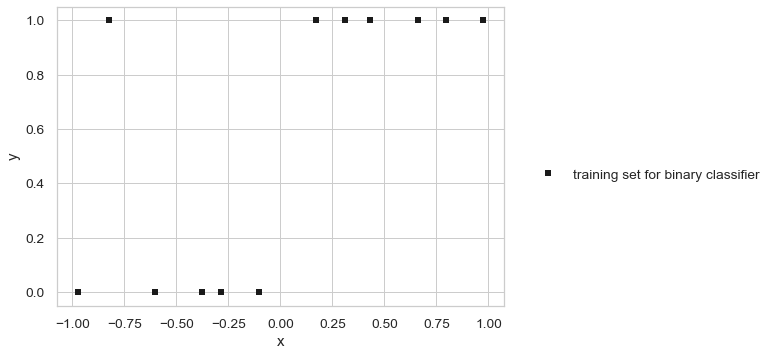

In [6]:
plt.plot(x_N, y_N, 'ks', label='training set for binary classifier');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.6, 0.5));

# Part 1: Comparing SVM and Logistic Regression on 1D Toy Outlier Data

### Train a Logistic Regression model: Minimize log loss + penalty on weights

$$
\min_{w, b} \quad C \sum_{n=1}^N \text{log_loss}\left(y_n, \sigma(w x_n + b) \right) + \frac{1}{2} w^2 
$$

In [7]:
# Large C value means effectively the sum-of-squares penalty on the weights has little impact.
lr = sklearn.linear_model.LogisticRegression(C=100.0, solver='lbfgs')

In [8]:
lr.fit(x_N1, y_N)

LogisticRegression(C=100.0)

In [9]:
# This block of code will pretty print the w and b values found as a result of calling 'fit'
print("Trained LogisticRegression to minimize log loss")
print("Best w value: %.3f" % (lr.coef_[0]))
print("Best b value: %.3f" % (lr.intercept_))

Trained LogisticRegression to minimize log loss
Best w value: 3.141
Best b value: 0.541


### Exercise 1a: What is the value of the log loss with these parameters, for the *inlier* example x=-0.975, y=0

Remember:

$$
\text{log_loss}(y_n, w x_n + b) = \begin{cases}
 - \log \sigma( w x_n + b)  ~~~ &\text{if}~~ y_n = 1
 \\
 - \log (1 - \sigma( w x_n + b))  ~~~ &\text{if}~~ y_n = 0
\end{cases}
$$

TODO manually compute this value to nearest 0.1

### Exercise 1b: What is the value of the log loss with these parameters, for the *outlier*: x=-0.825, y = 1

TODO manually compute this value to nearest 0.1

### Check your answers

In [10]:
def calc_log_loss(w, b, x_N, y_N):
    ''' Compute log loss on a dataset of N examples
    
    Sums over all examples, computing log loss at each x_n, y_n pair
    
    Returns
    -------
    log_loss_val : float
        Scalar value of total log loss (summed over N examples)
    '''
    # Convert x_N from a float scalar to a 1D array of size 1, if needed
    x_N = np.atleast_1d(x_N)
    y_N = np.atleast_1d(y_N)
    yproba1_N = logistic_sigmoid(w * x_N + b)
    log_loss_val = sklearn.metrics.log_loss(y_N, yproba1_N, labels=[0, 1]) / np.log(2.0)
    return log_loss_val

In [11]:
calc_log_loss(3.141, 0.541, -0.975, 0)

0.11148677987454526

In [12]:
calc_log_loss(3.141, 0.541, -0.825, 1)

3.1326469333194114

Don't worry too much about what these relative values *mean* just yet. We'll make plots soon.

The purpose so far is to just verify you are following along with core concepts (how each model assigns loss to an input example).

### Train an SVM: Minimize hinge loss + penalty on weights

Now let's try minimizing a different objective, using *hinge loss* instead of log loss.


$$
\min_{w, b} \quad C \sum_{n=1}^N \text{hinge_loss}\left(y_n, w x_n + b \right) + \frac{1}{2} w^2 
$$

In [13]:
svm = sklearn.svm.SVC(C=100., kernel='linear')

In [14]:
svm.fit(x_N1, y_N)

SVC(C=100.0, kernel='linear')

In [15]:
# This block of code will pretty print the w and b values found as a result of calling 'fit'
print("Trained SVM to minimize hinge loss")
print("Best w value: %.3f" % (svm.coef_[0]))
print("Best b value: %.3f" % (svm.intercept_))

Trained SVM to minimize hinge loss
Best w value: 2.903
Best b value: 0.097


### Discussion 1c: What is the difference between the learned weights and learned bias above compared to LR?

Which parameter (weight or bias) has a *larger* difference? Why do you think that is?

TODO discuss.

### Exercise 1d: What is the value of the hinge loss with these parameters, for *inlier* example x=-0.975, y=0

Remember:

$$
\text{hinge_loss}(y_n, w x_n + b) = \begin{cases}
 \max(0, 1 - (w x_n + b))  ~~~ &\text{if}~~ y_n = 1
 \\
 \max(0, 1 + (w x_n + b)))  ~~~ &\text{if}~~ y_n = 0
\end{cases}
$$

TODO compute manually to nearest 0.1

### Exercise 1e: What is the value of the hinge loss with these parameters, for the *outlier*: x=-0.825, y = 1

TODO compute manually to nearest 0.1

### Check your answers

In [16]:
def calc_hinge_loss(w, b, x_N, y_N):
    ''' Compute hinge loss on a dataset of N examples
    
    Sums over all examples, computing hinge loss at each x_n, y_n pair
    
    Returns
    -------
    hinge_loss_val : float
        Scalar value of total hinge loss (summed over N examples)
    '''
    # Convert x_N from a float scalar to a 1D array of size 1, if needed
    x_N = np.atleast_1d(x_N)
    score_N = w * x_N + b
    
    ysign_N = np.atleast_1d(np.sign(y_N-0.01)) # Convert binary 0/1 to signed -1/+1
    hinge_loss_val = np.sum(np.maximum(0, 1 - ysign_N * score_N))
    return hinge_loss_val

In [17]:
calc_hinge_loss(2.9, 0.1, -0.975, 0)

0.0

In [18]:
calc_hinge_loss(2.9, 0.1, -0.825, 1)

3.2924999999999995

Again, don't worry too much about what these relative values *mean* just yet. We'll make plots soon.

The purpose so far is to just verify you are following along with core concepts (how each model assigns loss to an input example).

## Plot the learned decision boundary for LR and SVM side-by-side

OK now let's get some intuition about what these different solutions for LR and SVM mean,
by making a plot.

Remember:
* LR = logistic regression (a probabilistic classifier), using log loss
* SVM = support vector machine (a non-probabilistic classifier), using hinge loss

In [19]:
# Prep for plotting by creating dense grid of x values
L = 101
xgrid_L1 = np.linspace(-2.0, 2.0, L).reshape((L,1));

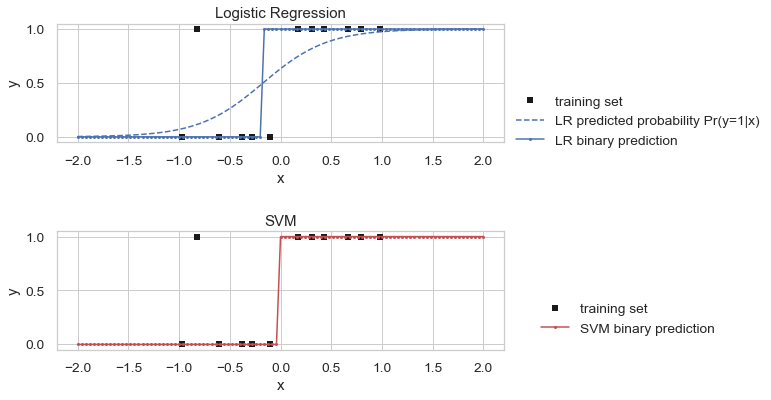

In [20]:
# Make plot of predictions for both methods
fig, axgrid = plt.subplots(nrows=2, ncols=1, figsize=(8,6))

# Plot Logistic Regression
axgrid[0].plot(x_N, y_N, 'ks', label='training set');
axgrid[0].plot(xgrid_L1, lr.predict_proba(xgrid_L1)[:,1], 'b--', label='LR predicted probability Pr(y=1|x)')
axgrid[0].plot(xgrid_L1, lr.predict(xgrid_L1), 'b.-', label='LR binary prediction');
axgrid[0].legend(bbox_to_anchor=(1.0, 0.5));
axgrid[0].set_title("Logistic Regression");
axgrid[0].set_xlabel("x");
axgrid[0].set_ylabel("y");

# Plot SVM!
axgrid[1].plot(x_N, y_N, 'ks', label='training set');
axgrid[1].plot(xgrid_L1, svm.predict(xgrid_L1), 'r.-', label='SVM binary prediction');
axgrid[1].legend(bbox_to_anchor=(1.5, 0.5));
axgrid[1].set_title("SVM");
axgrid[1].set_xlabel("x");
axgrid[1].set_ylabel("y");

plt.subplots_adjust(hspace=0.75); # Get vertical spacing right.

### Exercise 1e: What is the error rate on the training set for each classifier here?


TODO compute error rate (by visually inspecting the plots above). Can express as a fraction or decimal number.

### Check your answer

In [21]:
# LR error rate on the N training examples
lr_error_rate = 1.0 - lr.score(x_N1, y_N)
print(lr_error_rate)

0.16666666666666663


In [22]:
# SVM error rate on the N training examples
svm_error_rate = 1.0 - svm.score(x_N1, y_N)
print(svm_error_rate)

0.08333333333333337


### Discussion 1f: Suppose the outlier point did not exist. Which classifier's boundary would change more? Why?


TODO discuss. If you want, you can try it out.

## Setup for Parts 2 and 3

### Define simple dataset of points in 2D space

Don't worry about the details of this setup.
Just try to understand the plots below.

In [23]:
def create_2d_dataset(N=100, noise_stddev=0.1, random_state=0, n_outliers=0):
    random_state = np.random.RandomState(int(random_state))

    mA_2 = np.asarray([1, 0])
    covA_22 = np.square(noise_stddev) * np.eye(2)
    
    mB_2 = np.asarray([1, 1])
    covB_22 = np.square(noise_stddev) * np.eye(2)

    mC_2 = np.asarray([0, 1])
    covC_22 = np.square(noise_stddev) * np.eye(2)

    # Draw data from 3 "Gaussian" blobs
    xA_N2 = random_state.multivariate_normal(mA_2, covA_22, size=N)
    xB_N2 = random_state.multivariate_normal(mB_2, covB_22, size=N)
    xC_N2 = random_state.multivariate_normal(mC_2, covC_22, size=N)

    xD_O2 = random_state.multivariate_normal([1.5, -1], 2 * covB_22, size=n_outliers)

    x_N2 = np.vstack([xA_N2, xB_N2, xC_N2, xD_O2])
    y_N = np.hstack([
        np.ones(xA_N2.shape[0]), np.zeros(xB_N2.shape[0]), np.ones(xC_N2.shape[0]),
        np.zeros(xD_O2.shape[0])])
    
    return x_N2, y_N

### Create simple F=2 dataset and visualize it

Training data for a *clean* dataset will be stored in these arrays:

* x_tr_N2
* y_tr_N

Training data for a *messy* dataset (with outliers) will be stored in these arrays:

* xmessy_tr_N2
* ymessy_tr_N

Create utility function to plot data

In [24]:
def plot_pretty_data_colored_by_labels(x_N2, y_N):
    plt.plot(x_N2[y_N==0,0], x_N2[y_N==0,1], color='r', marker='x', linestyle='', markersize=5, mew=2, label='y=0');
    plt.plot(x_N2[y_N==1,0], x_N2[y_N==1,1], color='b', marker='+', linestyle='', markersize=8, mew=2, label='y=1');

### Create and plot a dataset that is clean (no intentional outliers)

In [25]:
x_tr_N2, y_tr_N = create_2d_dataset(N=100, noise_stddev=0.2, n_outliers=0)

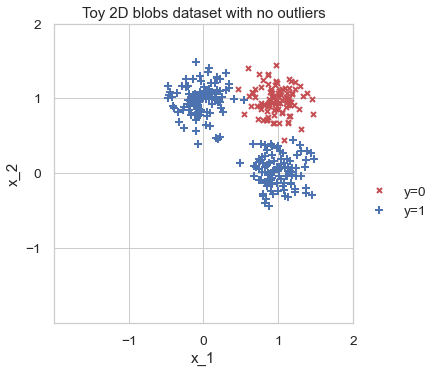

In [26]:
plot_pretty_data_colored_by_labels(x_tr_N2, y_tr_N);
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.xlabel('x_1');
plt.ylabel('x_2');
plt.gca().set_aspect(1.0);
plt.xticks([-1, 0, 1, 2]);
plt.yticks([-1, 0, 1, 2]);
plt.xlim([-2, 2]);
plt.ylim([-2, 2]);
plt.title("Toy 2D blobs dataset with no outliers");

### Create and plot a dataset with some NOTICEABLE outliers

In [27]:
xmessy_tr_N2, ymessy_tr_N = create_2d_dataset(N=100, noise_stddev=0.2, n_outliers=15)

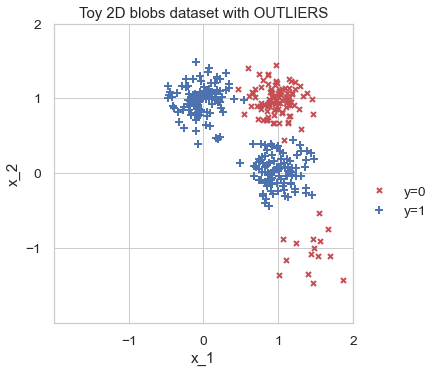

In [28]:
plot_pretty_data_colored_by_labels(xmessy_tr_N2, ymessy_tr_N);
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.xlabel('x_1');
plt.ylabel('x_2');
plt.gca().set_aspect(1.0);
plt.xticks([-1, 0, 1, 2]);
plt.yticks([-1, 0, 1, 2]);
plt.xlim([-2, 2]);
plt.ylim([-2, 2]);
plt.title("Toy 2D blobs dataset with OUTLIERS");

### Create a plot a validation set for us to use to select hyperparameters

In [29]:
x_va_N2, y_va_N = create_2d_dataset(N=100, noise_stddev=0.2, n_outliers=0, random_state=505)

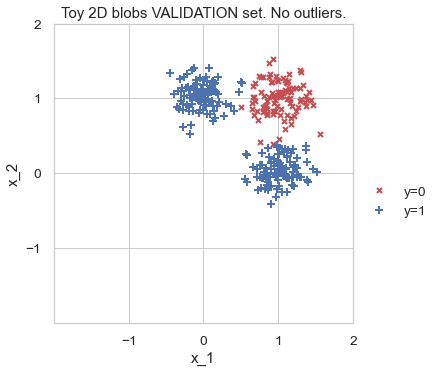

In [30]:
plot_pretty_data_colored_by_labels(x_va_N2, y_va_N);
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.xlabel('x_1');
plt.ylabel('x_2');
plt.gca().set_aspect(1.0);
plt.xticks([-1, 0, 1, 2]);
plt.yticks([-1, 0, 1, 2]);
plt.xlim([-2, 2]);
plt.ylim([-2, 2]);
plt.title("Toy 2D blobs VALIDATION set. No outliers."); 

### Define function to make pretty plots of predicted probability color fields

You don't need to understand this in detail. Just a utility function.

In [31]:
def plot_pretty_decision_boundaries_for_clf(
        clf,
        do_show_colorbar=False,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-2, 2.3, 100),
        x2_grid=np.linspace(-2, 2.3, 100)):
    cur_ax = plt.gca()
    
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Predict proba for each point in the flattened grid
    yhat_M = clf.predict(x_M2)
    
    # Reshape the M probas into the GxH 2D field
    yhat_GH = np.reshape(yhat_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yhat_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);

# Part 2: Visualizations of LR and SVM on a clean 2-feature dataset

We want to compare *relative* performance of the SVM and LR for this binary classification task

### First try SVM. We'll be visualizing binary decisions for a trained SVM at various C values

SVM
---
C =  0.0001 | tr error 0.333 | va error 0.333 | Learned weights + bias
                                              [-0.00358783 -0.0037053   1.00371207]
SVM
---
C =   0.01 | tr error 0.333 | va error 0.333 | Learned weights + bias
                                              [-0.34491506 -0.36910696  1.34975881]
SVM
---
C =      1 | tr error 0.047 | va error 0.043 | Learned weights + bias
                                              [-3.53411815 -3.65276991  5.59115907]
SVM
---
C =  1e+02 | tr error 0.047 | va error 0.043 | Learned weights + bias
                                              [-8.0626156  -8.33460046 12.69756983]
SVM
---
C =  1e+04 | tr error 0.050 | va error 0.043 | Learned weights + bias
                                              [-8.98418279 -9.63935861 14.51028144]


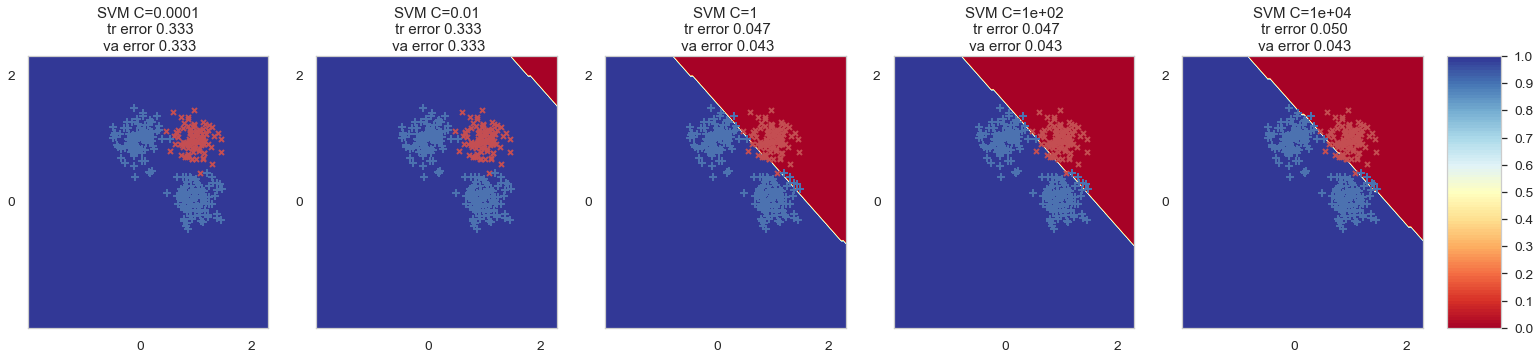

In [32]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 10000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.svm.SVC(C=C, kernel='linear')
    clf.fit(x_tr_N2, y_tr_N)
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_tr_N2, y_tr_N);

    tr_error_rate = sklearn.metrics.zero_one_loss(y_tr_N, clf.predict(x_tr_N2))
    va_error_rate = sklearn.metrics.zero_one_loss(y_va_N, clf.predict(x_va_N2))
    
    plt.title("SVM C=%.2g\n tr error %.3f\n va error %.3f" % (C, tr_error_rate, va_error_rate))
    print("SVM")
    print("---")
    print("C = % 6.2g | tr error %.3f | va error %.3f | Learned weights + bias" % (C, tr_error_rate, va_error_rate))
    print("                                              " + str(
        np.hstack([clf.coef_.flatten(), np.atleast_1d(clf.intercept_)])))

### Discussion 2a: Pick the best C hyperparameter according to validation error rate. What error rate do you get? 


TODO answer

### Now look at LR: Visualizing binary decisions for LogisticRegression at various C values

To make things fair to SVMs, we'll avoid thinking of LR as *probabilistic* here, and just use its hard binary decisions by thresholding at 0.5.

LR
---
C =  0.0001 | tr error 0.333 | va error 0.333 | Learned weights + bias
                                              [-0.00321473 -0.00315365  0.69732289]
LR
---
C =   0.01 | tr error 0.333 | va error 0.333 | Learned weights + bias
                                              [-0.29151053 -0.29063966  1.07876757]
LR
---
C =      1 | tr error 0.047 | va error 0.040 | Learned weights + bias
                                              [-4.57257322 -4.80632246  7.46421963]
LR
---
C =  1e+02 | tr error 0.047 | va error 0.043 | Learned weights + bias
                                              [-12.45229956 -13.58777013  20.38060608]
LR
---
C =  1e+04 | tr error 0.047 | va error 0.043 | Learned weights + bias
                                              [-13.97927087 -15.35847404  22.97291159]


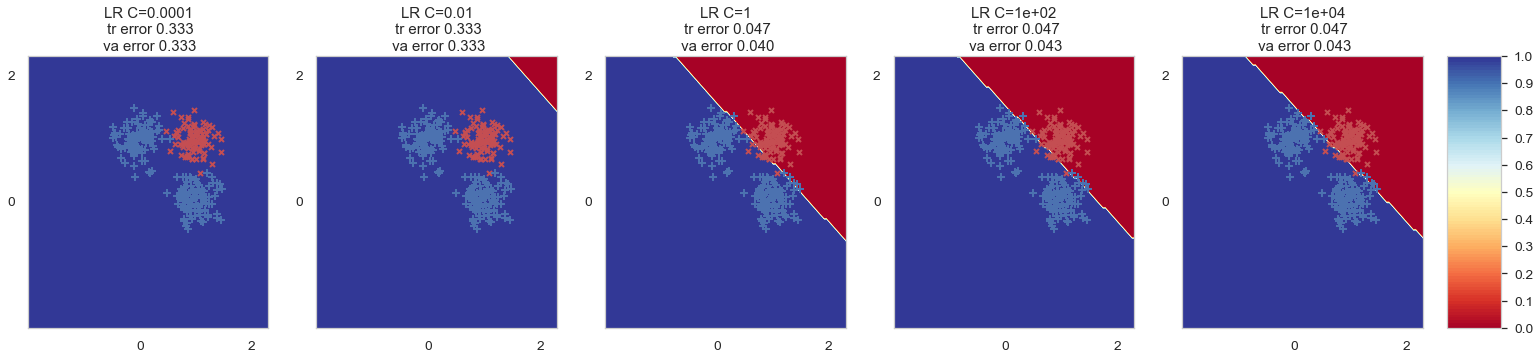

In [33]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 10000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.linear_model.LogisticRegression(C=C)
    clf.fit(x_tr_N2, y_tr_N)
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(x_tr_N2, y_tr_N);

    tr_error_rate = sklearn.metrics.zero_one_loss(y_tr_N, clf.predict(x_tr_N2))
    va_error_rate = sklearn.metrics.zero_one_loss(y_va_N, clf.predict(x_va_N2))
    
    plt.title("LR C=%.2g\n tr error %.3f\n va error %.3f" % (C, tr_error_rate, va_error_rate))
    print("LR")
    print("---")
    print("C = % 6.2g | tr error %.3f | va error %.3f | Learned weights + bias" % (C, tr_error_rate, va_error_rate))
    print("                                              " + str(
        np.hstack([clf.coef_.flatten(), np.atleast_1d(clf.intercept_)])))

### Discussion 2b: Pick the best C hyperparameter according to validation error rate. What error rate do you get? 

* How does this SVM model compare to the non-outlier SVM model from 3a?

# Part 3: Visualizations comparing LR vs SVM with outliers

Now try again with the extra outliers version of the dataset

Again we want to compare *relative* performance of the SVM and LR for this binary classification task

### Outlier data: Visualizing hard decisions for SVM at various C values

LR
---
C =  0.0001 | tr error 0.365 | va error 0.333 | Learned weights + bias
                                              [-0.00338687 -0.00300296  1.00306332]
LR
---
C =   0.01 | tr error 0.365 | va error 0.333 | Learned weights + bias
                                              [-0.34770616 -0.28824071  1.29882987]
LR
---
C =      1 | tr error 0.095 | va error 0.060 | Learned weights + bias
                                              [-2.98366108 -2.32754626  4.15299339]
LR
---
C =  1e+02 | tr error 0.092 | va error 0.063 | Learned weights + bias
                                              [-3.53651989 -2.61784255  4.76769463]
LR
---
C =  1e+04 | tr error 0.092 | va error 0.063 | Learned weights + bias
                                              [-3.51964558 -2.60777035  4.75056165]


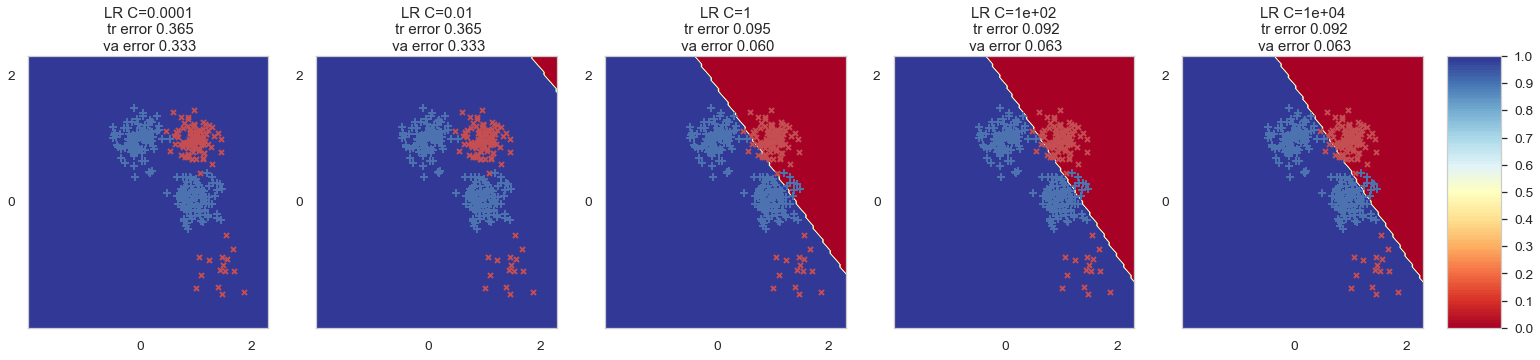

In [34]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 10000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.svm.SVC(C=C, kernel='linear')
    clf.fit(xmessy_tr_N2, ymessy_tr_N)
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(xmessy_tr_N2, ymessy_tr_N);

    tr_error_rate = sklearn.metrics.zero_one_loss(ymessy_tr_N, clf.predict(xmessy_tr_N2))
    va_error_rate = sklearn.metrics.zero_one_loss(y_va_N, clf.predict(x_va_N2))
    
    plt.title("LR C=%.2g\n tr error %.3f\n va error %.3f" % (C, tr_error_rate, va_error_rate))
    print("LR")
    print("---")
    print("C = % 6.2g | tr error %.3f | va error %.3f | Learned weights + bias" % (C, tr_error_rate, va_error_rate))
    print("                                              " + str(
        np.hstack([clf.coef_.flatten(), np.atleast_1d(clf.intercept_)])))

### Discussion 3a: Pick the best C hyperparameter according to validation error rate. What error rate do you get? 

* How does this SVM model compare to the non-outlier SVM model from 2a?

TODO describe.

### Outlier Data: Visualizing hard decisions for LogisticRegression at various C values

LR
---
C =  0.0001 | tr error 0.365 | va error 0.333 | Learned weights + bias
                                              [-0.00395968 -0.00151347  0.55698266]
LR
---
C =   0.01 | tr error 0.365 | va error 0.333 | Learned weights + bias
                                              [-0.34439614 -0.15200914  0.88146134]
LR
---
C =      1 | tr error 0.111 | va error 0.113 | Learned weights + bias
                                              [-4.1632861  -2.28882097  5.13362375]
LR
---
C =  1e+02 | tr error 0.121 | va error 0.117 | Learned weights + bias
                                              [-5.81178062 -3.08368767  7.01510205]
LR
---
C =  1e+04 | tr error 0.121 | va error 0.117 | Learned weights + bias
                                              [-5.84440769 -3.09864653  7.05234616]


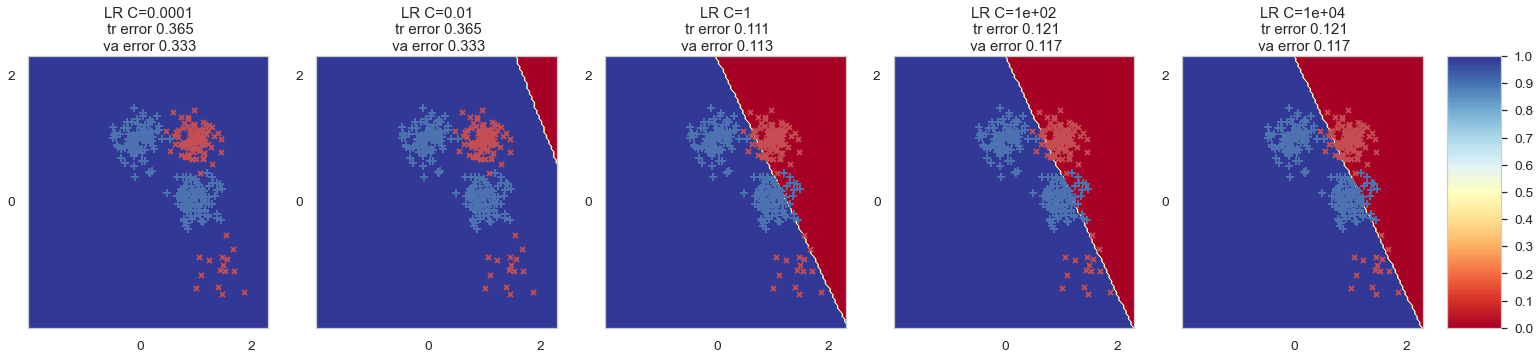

In [35]:
C_grid = np.asarray([0.0001, 0.01, 1, 100, 10000])
ncols = len(C_grid)

fig_h, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5))

is_last = False
for ii, C in enumerate(C_grid):
    if ii == ncols - 1:
        is_last = True
    plt.sca(axes[ii])
    clf = sklearn.linear_model.LogisticRegression(C=C)
    clf.fit(xmessy_tr_N2, ymessy_tr_N)
    plot_pretty_decision_boundaries_for_clf(clf, do_show_colorbar=is_last);
    plot_pretty_data_colored_by_labels(xmessy_tr_N2, ymessy_tr_N);

    tr_error_rate = sklearn.metrics.zero_one_loss(ymessy_tr_N, clf.predict(xmessy_tr_N2))
    va_error_rate = sklearn.metrics.zero_one_loss(y_va_N, clf.predict(x_va_N2))
    
    plt.title("LR C=%.2g\n tr error %.3f\n va error %.3f" % (C, tr_error_rate, va_error_rate))
    print("LR")
    print("---")
    print("C = % 6.2g | tr error %.3f | va error %.3f | Learned weights + bias" % (C, tr_error_rate, va_error_rate))
    print("                                              " + str(
        np.hstack([clf.coef_.flatten(), np.atleast_1d(clf.intercept_)])))

### Discussion 3b: Pick the best C hyperparameter according to validation error rate. What error rate do you get? 

* How does this LR model compare to the SVM trained on outliers from 3a?
* How does this LR model compare to the non-outlier LR model from 2b?

TODO answer

### Discussion 3c: What visually happens to the decision boundary because of the outliers in logistic regression compared to SVM? Why?

TODO answer